In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import tensorflow as tf

sys.path.append('../az_training/alexey_kozhevin/')

from dataset.models.tf import TFModel, VGG7
from dataset.models.tf.faster_rcnn import *
from dataset.models.tf.layers import conv_block, global_average_pooling
from tqdm import tqdm
from dataset import B, V, C, Pipeline
from dataset.opensets import MNIST
from detection_mnist import DetectionMnist
%matplotlib inline

In [2]:
IMAGE_SHAPE = (128, 128)
MNIST_PER_IMAGE = 4
BATCH_SIZE = 15
RESIZE_TO = (28, 28)
ANCHORS_BATCH_SIZE = 16

In [3]:
sess = tf.Session()

with sess.graph.as_default():

    inputs = tf.placeholder(tf.float32, (None,) + IMAGE_SHAPE + (1,))
    #simple_mnist = tf.placeholder(tf.float32, [None, 28, 28, 1])
    #simple_mnist_labels = tf.placeholder(tf.int32, [None])
    batch_mode = tf.placeholder(tf.bool)
    
    b_norm = {'momentum': 0.1, 'training': batch_mode}
    #pretrain = VGG7.body(simple_mnist, batch_norm=b_norm)   
    #pretrain = conv_block(pretrain, 'fff', units=[100,100,10], name='pretrain')
                         
    #loss0 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=simple_mnist_labels, logits = pretrain))   
    
    #b_norm['reuse'] = True
    feature_maps = VGG7.body(inputs, batch_norm=b_norm)#, conv={'reuse': True})   
    rpn_reg, rpn_cls, n_anchors = rpn(feature_maps)

    anchors = tf.placeholder(tf.float32, shape=[n_anchors, 4], name='anchors')
    anchors_batch = tf.placeholder(tf.float32, shape=[None, n_anchors], name='anchors_batch')
    anchors_cls = tf.placeholder(tf.float32, shape = [None, n_anchors], name='anchors_cls')
    anchors_reg = tf.placeholder(tf.float32, shape = [None, n_anchors, 4], name='anchors_reg')

    bbox_labels = tf.placeholder(tf.int32, shape=[None, n_anchors], name='labels')

    # parametrize reg
    anchors_reg_param = parametrize(anchors_reg, anchors)

    # unparametrize reg and clsf
    rpn_reg_unparam = unparametrize(rpn_reg, anchors)
    rpn_cls_unparam = tf.sigmoid(rpn_cls)
    
    # perform NMS on RPN inputs
    rcn_input_indices = non_max_suppression(rpn_reg_unparam, rpn_cls_unparam, BATCH_SIZE, n_anchors, 
                                            iou_threshold=0.5, score_threshold=0.7)
    rcn_input_rois, rcn_input_labels = get_rois_and_labels(rpn_reg_unparam, bbox_labels, rcn_input_indices, BATCH_SIZE)

    roi_factor = np.array(feature_maps.get_shape().as_list()[1:3]) / np.array(inputs.get_shape().as_list()[1:3])
    
    roi_cropped, rcn_input_labels = roi_pooling_layer(feature_maps, rcn_input_rois, rcn_input_labels, roi_factor, shape=(7, 7))

    net = conv_block(roi_cropped, 'cacaca', filters=512, kernel_size=3, name='preoutput')
    net = conv_block(net, 'ca', filters=10, kernel_size=3, name='output_conv')
    output_cls = global_average_pooling(net, name='output')
    
    loss1 = rpn_loss(rpn_reg, rpn_cls, anchors_reg_param, anchors_cls, anchors_batch)
    loss2 = rcn_loss(output_cls, rcn_input_labels)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        opt1 = tf.train.AdamOptimizer()
        train_step1 = opt1.minimize(loss1)

        opt2 = tf.train.AdamOptimizer()
        train_step2 = opt2.minimize(loss2)
    
    #opt0 = tf.train.AdamOptimizer()
    #train_step0 = opt0.minimize(loss0)

In [4]:
sess.run(tf.global_variables_initializer())

# mnist = MNIST()
# ppl = mnist.train.p
# for i in range(1000):
#     batch = ppl.next_batch(100, n_epochs=None, shuffle=True)
#     feed_dict = {simple_mnist: batch.data.images,
#                  simple_mnist_labels: batch.data.labels,
#                  batch_mode: True}
#     _, train_loss0 = sess.run([train_step0, loss0], feed_dict)
# print(train_loss0)

In [5]:
mnist = MNIST(batch_class=DetectionMnist)

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz





In [6]:
ppl_cfg = dict(rpn=dict(output_map_shape=feature_maps.get_shape().as_list()[1:3]))
train_pp = (Pipeline(config=ppl_cfg)
            .init_variable('loss_history', init_on_each_run=list)
            .generate_images(image_shape=IMAGE_SHAPE, n_digits=MNIST_PER_IMAGE, resize_to=RESIZE_TO)
            .create_anchors(IMAGE_SHAPE)
            .create_reg_cls()
            .batch_anchors(batch_size = ANCHORS_BATCH_SIZE)
            .transform_clsf()
            )
train_pp = train_pp << mnist.train

In [7]:
for i in range(100):
    batch = train_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    labels = batch.data.bboxes_labels
    labels[batch.data.clsf < 0.2] = 10
    
    def B(name):
        return getattr(batch.data, name)

    feed_dict = {inputs: B('images'),
                 batch_mode: True,
                 anchors_cls: B('clsf'),
                 anchors_reg: B('reg'),
                 bbox_labels: labels,
                 anchors_batch: B('anchor_batch'),
                 anchors: B('anchors')} 
    #from collections import Counter
    #print(Counter(sess.run(rcn_input_labels, feed_dict)))
    
    
    _, train_loss1, train_loss2 = sess.run([train_step1, loss1, loss1], feed_dict=feed_dict)
    #_, train_loss1, train_loss2 = sess.run([train_step2, loss1, loss2], feed_dict=feed_dict)
print("Opt1: {:6.3f}, {:6.3f}".format(train_loss1, train_loss2))    

Opt1:  0.021,  0.021


In [8]:
test_pp = (Pipeline(config=train_pp.config)
            .init_variable('loss_history', init_on_each_run=list)
            .generate_images(image_shape=IMAGE_SHAPE, n_digits=MNIST_PER_IMAGE, resize_to=RESIZE_TO)
            .create_anchors(IMAGE_SHAPE)
            .create_reg_cls()
            .batch_anchors(batch_size=ANCHORS_BATCH_SIZE)
            .transform_clsf()
          )
test_pp = test_pp << mnist.test

In [9]:
batch = test_pp.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)

labels = batch.data.bboxes_labels
#labels[batch.data.clsf < 0.2] = 10

def B(name):
    return getattr(batch.data, name)

feed_dict = {inputs: B('images'),
             batch_mode: False,
             anchors_cls: B('clsf'),
             anchors_reg: B('reg'),
             bbox_labels: labels,
             anchors_batch: B('anchor_batch'),
             anchors: B('anchors')} 

roi, ind = sess.run([rpn_reg_unparam, rcn_input_indices], feed_dict=feed_dict)

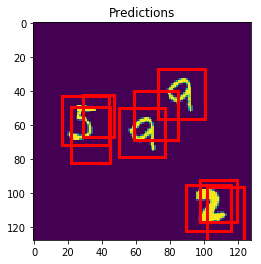

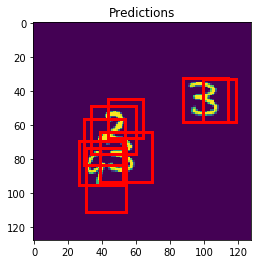

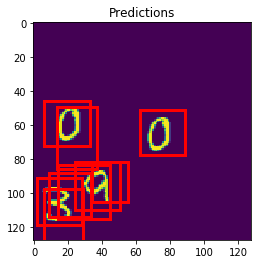

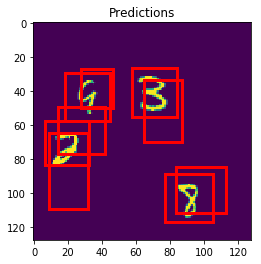

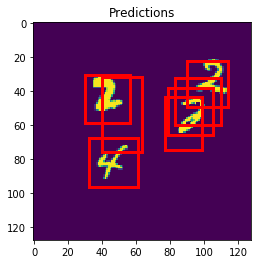

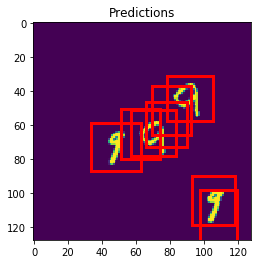

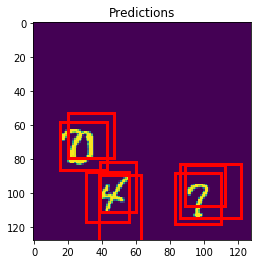

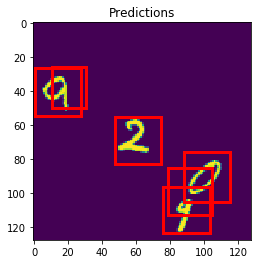

In [10]:
for i in range(8):
    im = batch.data.images[i, :, :, 0]
    bboxes = roi[i]
    bboxes = bboxes[np.squeeze(ind[i])]

    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for bbox in bboxes:      
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=3, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    plt.title('Predictions')
    plt.show()